# Parking Meter Tools

## Function list.  To reload and update, uncomment first line and rerun cell
# If you Make changes inside Jupyter Notebooks, uncomment '%%writefile functions.py' at the top and rerun the cell.
# If that file already existed, _the existing contents will be overwritten_

In [1]:
from colour import Color #pip install colour
import time as tm

In [2]:
# %%writefile functions.py
# %load functions.py
import pandas as pd
import pickle
from collections import *
import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from collections import Counter as ctr
from sklearn.model_selection import train_test_split
from math import *
import datetime
from multiprocessing import Process, Queue, Pool
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

MeterData = None


# Load the MeterData from a pickle file or from the provided files
def Load(pickled=False, csv_name='data/Boise_all.csv', inventory_xlsx='data/Sensor_Inventory_Detail.xlsx', coordinates='data/Subareas_Coordinates2.xlsx'):
    if pickled:
        with open("data/boisePM_Zone.p", "rb") as iFile:
            return pickle.load(iFile)
    else:
        #This is for first time reading, save dataframe to pickle file for loading later.
        print("check 0")
        chunk_size = 10000
        boisePM_chunks=[]
        for chunk in pd.read_csv(csv_name, engine='python',
                     chunksize=chunk_size, encoding='utf-8', skiprows=[0],
                     names=['Meter', 'EventTime', 'EventType', 'Amount', 'Time', 'MeterExpires', 'PaymentType']):
            boisePM_chunks.append(chunk)

        boisePM = pd.concat(boisePM_chunks)
        #pickle.dump(boisePM, open( "data/boisePM.p", "wb" ))
        print("check 1")

        # Sort by meter and time
        boisePM.sort_values(['Meter','EventTime'], inplace=True)
        
        
        boisePM['EventTime'] = pd.to_datetime(boisePM['EventTime'])
        boisePM = boisePM.loc[(boisePM['EventTime'] > datetime.date(2017,12,31))
                           &(boisePM['EventTime'] < datetime.date(2019,1,1))]
        
        print("check2")

        # Read in Area/Zone info for meters
        zoneInfo = pd.read_excel(inventory_xlsx)
        zoneInfo.drop(columns=['RFID','Current Firmware Version','Configuration','Binding Code', 'Area'], inplace=True)
        zoneInfo = zoneInfo[zoneInfo.Zone.str.contains("Spares") == False]

        # Merge the meter and area/zone information
        boisePM_Zone = pd.merge(zoneInfo, boisePM, left_on='Pole', right_on='Meter'). drop(columns=['Pole','Terminal']).sort_values(['Zone','Meter','EventTime'])
        #print(boisePM_Zone)
        boisePM_Zone.rename(columns={"Sub Area " : "Area"}, inplace=True)
        #print(boisePM_Zone)

        # Read in coordinate data and merge into the meter data
        a = pd.read_excel(coordinates, header=0)
        #print(a)
        areas = boisePM_Zone[boisePM_Zone['Area'].isin(a['Sub Area '])].Area.unique()
        a = a[a['Sub Area '].isin(areas)]
        boisePM_Zone = pd.merge(a, boisePM_Zone, left_on='Sub Area ', right_on='Area').sort_values(['Meter','EventTime'])
        boisePM_Zone.drop(columns=['Zone_y','Area_x','Notes','Area_y'], inplace=True)
        boisePM_Zone.rename(columns={'Zone_x':'Zone','Sub Area ':'Area'}, inplace=True)

        # Set event times to datetime objects, split day/time into columns, split Lat/Long into columns
        latlong = boisePM_Zone['Location'].str.split(",", expand=True)
        boisePM_Zone['Latitude'] = latlong[0].astype(float)
        boisePM_Zone['Longitude'] = latlong[1].astype(float)
        boisePM_Zone.drop(columns=['Location'], inplace=True)
        boisePM_Zone['EventTime'] = pd.to_datetime(boisePM_Zone['EventTime'])
        boisePM_Zone['Day'] = [d.date() for d in boisePM_Zone['EventTime']]
        boisePM_Zone['DayOfWeek'] = [d.weekday() for d in boisePM_Zone['Day']]
        boisePM_Zone['Clock'] = [d.time() for d in boisePM_Zone['EventTime']]
        # Save to file
        pickle.dump(boisePM_Zone, open( "data/boisePM_Zone.p", "wb" ))
        return boisePM_Zone

# Flatten all related status' to "Occupied" or "Available"
def FlattenStatus(data, zone=None, areas=None, meter=None,
                  date_start=None, date_end=None, melt=False, max_procs=1):
    #print("*********")
    #print(data.head())
    #BRODY: Filters to given zone, areas, meter, etc.
    def Filter(out, zone=None, areas=None, meter=None,
              date_start=None, date_end=None):
        if zone != None:
            out = out.loc[out.Zone == zone]
        if areas != None:
            out = out.loc[out.Area.isin(areas)]
        if meter != None:
            out = out.loc[out.Meter == meter]
        if date_start != None:
            if date_end != None:
                out = out.loc[(out.Day >= date_start) & (out.Day <= date_end)]
            else:
                out = out.loc[out.Day >= date_start]
        return out
    
    outcol = ['Zone', 'Meter', 'EventTime', 'EventType', 'Time',
               'Availability', 'Area', 'DayOfWeek', 'Day', 'Clock', 'Latitude',
               'Longitude', 'Location_Ending_Longitude', 'Location_Ending_Latitude',
             'Location_Starting_Longitude', 'Location_Starting_Latitude']
    #print("starting...")
    # If max_procs > 1, perform mutli-threaded melt
    # BRODY: Doesn't seem to work properly -- using 1 proc is much quicker
    if max_procs > 1:
        pool = Pool(processes=max_procs)
        copiedData = data.copy(deep=True)
        copiedData = Filter(copiedData, zone, areas, meter, date_start, date_end)
        outData = pd.DataFrame(columns=outcol)
        
        if areas == None:
            areas = copiedData.Area.unique()
        # Split function call across pool
        results = [pool.apply_async(FlattenStatus,
                                        args=(copiedData, None, [area], None, None, True, 1))
                                   for area in areas]
        # Collect results from pool
        results = [p.get() for p in results]
        # Squish results back into one pandas frame
        for result in results:
            outData = outData.append(result)
        pool.close()
        pool.join()
        return outData
    else:
        #Filters data to specific zone, areas, meter, or dates
        out = Filter(data.copy(), zone, areas, meter, date_start, date_end)    
     
    #print("**********")
    #print(data.head())
    #BRODY: This converts all events that are not 'SpaceVacated' to 'SpaceOccupied' - intentional?
    out['Availability'] = np.where(out['EventType']=='Space Vacated', 'SpaceVacated', 'SpaceOccupied')
    
    #BRODY: only returns the columns defined in outcol
    out = out[outcol]
    if melt:
        print("starting melt...")
        out = MeltStatus(out)

    return out

# TODO: This is really, really, REALLY slow and easily takes the most time out of anything else
def MeltStatus(data):
    start_time = tm.time()
    #data.to_csv('premelt.csv')
    out = pd.DataFrame(columns=data.columns)
    availLoc = data.columns.get_loc('Availability')
    timeLoc = data.columns.get_loc('Time')
    eventLoc = data.columns.get_loc('EventTime')
    clockLoc = data.columns.get_loc('Clock')

    # Copy first entry into out
    t = data.iloc[0,clockLoc]
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    out.loc[0] = data.iloc[0]
    out.iloc[0,timeLoc] = seconds

    i = 1
    j = 1
    # It's pretty likely that this is where we're having the most slowdown, this loop isn't very pythonic
    # and is probably not leveraging the capabilities of Pandas very well (or at all)
    print("length", data.shape[0]-1)
    print("Time for set up: ", tm.time()-start_time)
    start_time = tm.time()
    #BRODY: it looks like this is looping through and taking the last occurence of any sequential "SpaceOccupied" and "SpaceAvailable"
   
    
    '''
    while i < data.shape[0]-1:
        time = data.iloc[i-1, eventLoc]
        
        out.loc[j] = data.iloc[i]
        out.iloc[j, timeLoc] = (data.iloc[i, eventLoc] - time).seconds
        if i % 1000 == 0:
            print(i)
            print(time)
        #BRODY: While the current availability and the next availability are the same...
        while (i < data.shape[0]-1 and data.iloc[i,availLoc] == data.iloc[i+1, availLoc]):
            i += 1
        #BRODY: Set the next value in OUT as the last occurence of sequential availability
        #out.loc[j] = data.iloc[i]
        #out.iloc[j, timeLoc] = (data.iloc[i, eventLoc] - time).seconds
        j += 1
        i +=1
    '''
    out = data[data.Availability.shift() != data.Availability]
    
    print("time for loop", tm.time()-start_time)
    if out.empty:
        raise ("Provided arguments yielded no matching rows")
    #out.to_csv('postmelt.csv')
    return out

# Expects a Flattened dataset
# Chunk events that cross over an marker into discrete, hourly-stepped events
# EX: Last event at 12:45, next event at 13:45
# -> Creates a new event that ends at 13:00, and lasts (time) 15 minutes
# -> Updates existing event to now reflect its time starting at 13:00 and ending 13:45
def ChunkHourly(data):
    eventloc = data.columns.get_loc('EventTime')
    timeloc = data.columns.get_loc('Time')
    times = data['EventTime']
    prev = times.iloc[0]
    initial_len = len(times)
    for i in range(1,initial_len):
        curr = times.iloc[i]
        if (prev.hour != curr.hour):
            if curr.hour < prev.hour:
                n = (24 - prev.hour) + curr.hour
            else:
                n = curr.hour - prev.hour

            time = prev.replace(hour=(prev.hour+1)%24, minute=0, second=0)
            length = (time - prev).total_seconds()
            row = data.iloc[i].copy(deep=True)
            row.loc['EventTime'] = time
            row.loc['Time'] = length
            data = data.append(row, ignore_index=True)
            for k in range(1,n):
                time = time.replace(hour=(time.hour+1)%24)
                length = 3600
                row = data.iloc[i].copy(deep=True)
                row.loc['EventTime'] = time
                row.loc['Time'] = length
                data = data.append(row, ignore_index=True)
            data.iloc[i,timeloc] = (data.iloc[i,eventloc] - row.EventTime).total_seconds()
        prev = curr
    data.sort_values(['Meter','EventTime'], inplace=True)
    data = data.reset_index(drop=True)
    return data

# Produce a line graph of total occupancy for a zone
# Assumes FlattenOccupied data list
def ZoneOccupationDaily(data, daterange=None):
    days = data.Day.unique()
    percent = []
    for day in days:
        d = data.loc[data.Day == day].groupby(['Availability'])['Time'].sum()
        percent.append(d.SpaceOccupied / (d.SpaceOccupied + d.SpaceVacated))

    fig, ax = plt.subplots()
    ax.plot(days, percent)

        
def AddTime(T1, T2, percent):
    start = (T1.hour*60)+T1.minute
    end = (T2.hour*60)+T2.minute
    percent[start:end] = list(map(lambda x: x+1, percent[start:end]))

def GetTimePercent(area, latitude, longitude, ending_long, ending_lat, starting_long, starting_lat, group, duration, days, cols):
    groupout = pd.DataFrame(columns=cols)
    for day in days:
        percent = [0.0]*1440
        for m, g in group.groupby(['Meter']):
            meter = g.loc[g['Day'] == day]
            
            # Skip empty records
            if meter.empty:
                continue
            time = datetime.time(0,0)

            # For every record for the meter for the day
            # add value if occupied for how many minutes
            for i in range(0, len(meter)):
                row = meter.iloc[i]
                if row.Availability == 'SpaceVacated':
                    AddTime(time, row.Clock, percent)
                time = row.Clock

            # If our last event was "Available" the next is "Occupied"
            # fill in data accordingly
            row = meter.iloc[len(meter)-1]
            if row.Availability != 'SpaceVacated':
                AddTime(row.Clock, datetime.time(23,59), percent)
                percent[-1] += 1

        # For every hour, calculate the percent the area was occupied
        # and add it as an entry
        for i in range(0, 1440, duration):
            occpercent = (sum(percent[i : (i+duration)-1]) / duration) / group.Meter.nunique()
            entry = pd.DataFrame(columns=cols, 
                                 data=[[area, day, day.weekday(), int(i/60), int(i%60), latitude, longitude,occpercent, ending_long, ending_lat, starting_long, starting_lat]])
            groupout = groupout.append(entry)
            
    return groupout
    
#########
# Gives average occupied time in duration increments for an area for multiple dates
# Expects that the data has already been chunked into desired date ranges and renamed
# Use the SplitAreaByDates function below to accomplish this
# EX: W. 9TH BANNOCK-JEFFERSON for July and August should be split into a new dataframe
# with each date range renaming the area as 'W. 9TH BANNOCK-JEFFERSON JUL' and AUG respectively
#########
def CompareDates(data, duration=60, weekdays=[0,1,2,3,4,5,6]):
    
    outcol = ['Area', 'Date', 'DayOfWeek', 'Hour', 'Minute', 'OccupiedPercent']
    if duration < 5:
        print("Duration too small, defaulting to 5 minutes")
        duration = 5
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for area, group in data.groupby(['Area']):
        days = [day for day in group.Day.unique() if day.weekday() in weekdays]
        groupout = GetTimePercent(area, group, duration, days, outcol)
        totalocc = [0.0]*int(1440/duration)
        times = []
        for i in range(0, 1440, duration):
            totalocc[int(i/duration)] = groupout.loc[
                (groupout['Hour'] == int(i/60))&(groupout['Minute'] == i%60)
                 ].OccupiedPercent.sum() / len(days)
            times.append(datetime.time(int(i/60), i%60))
        ax.plot(times, totalocc, label=area)
    
    ax.set_ylim(0,1)
    plt.legend(loc='best')
    plt.show()
            
    
#########
# Gives average occupied time in duration increments for collective areas
#########
def OccupiedTime(data, duration=60, weekdays=[0,1,2,3,4,5,6], graph=False, max_procs=1):
    outcol = ['Area', 'Date', 'DayOfWeek', 'Hour', 'Minute','Latitude','Longitude', 'OccupiedPercent', 'Location_Ending_Longitude', 'Location_Ending_Latitude',
             'Location_Starting_Longitude', 'Location_Starting_Latitude']
    out = pd.DataFrame(columns=outcol)
    
    # Only use days that match provided weekdays
    # Defaults to all
    days = [day for day in data.Day.unique() if day.weekday() in weekdays]
    
    if duration < 5:
        print("Duration too small, defaulting to 5 minutes")
        duration = 5
    
    # If we specify more than one processor, perform multi-threaded collections
    # Does NOT support graphing
    if max_procs > 1:
        pool = Pool(processes=max_procs) 
        results = [pool.apply_async(OccupiedTime, 
                                    args=(pd.DataFrame(data.loc[data['Area'] == area]), 
                                          duration, weekdays, False, 1))
                                   for area in data.Area.unique()]
        results = [p.get() for p in results]
        for result in results:
            out = out.append(result)
        
        pool.close()
        pool.join()
        return out
        
        
    if graph:
        fig=plt.figure()
        ax=fig.add_subplot(111)
        
    # For each area, for each day, for each meter, calculate occupation percentage
    print("number of areas: ", data.Area.nunique())
    i = 0
    start_time = tm.time()
    for area, group in data.groupby(['Area']):
        i += 1
        #print(area)
        #print(group)
        groupout = GetTimePercent(area, group['Latitude'].iloc[0], group['Longitude'].iloc[0], 
                                  group['Location_Ending_Longitude'].iloc[0], group['Location_Ending_Latitude'].iloc[0],
             group['Location_Starting_Longitude'].iloc[0], group['Location_Starting_Latitude'].iloc[0], group, duration, days, outcol)

        out = out.append(groupout)
        if graph:
            totalocc = [0.0]*int(1440/duration)
            times = []
            for i in range(0, 1440, duration):
                totalocc[int(i/duration)] = groupout.loc[
                    (groupout['Hour'] == int(i/60))&(groupout['Minute'] == i%60)
                     ].OccupiedPercent.sum() / len(days)
                times.append(datetime.time(int(i/60), i%60))
            #print(times)
            #print(totalocc)
            ax.plot(times, totalocc, label=area)
        print("processed area: ", i)
        print("time elapsed: ", tm.time()-start_time)

    if graph:
        ax.set_ylim(0,1)
        plt.legend(loc='best')
        plt.show()

    return out

###
# Get a graph and the data of occupation percentage by weekday
###
import calendar
def OccupationByWeekday(data, area, duration=60, graph=False):
    outcol = ['Area', 'Date', 'DayOfWeek', 'Hour', 'Minute', 'OccupiedPercent']
    out = pd.DataFrame(columns=outcol)
    
    if duration < 5:
        print("Duration too short.  Defaulting to 5min")
        duration = 5
    
    if graph:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    tmp = data.loc[data['Area']==area]
    for i in range(0,7):
        days = [day for day in tmp.Day.unique() if day.weekday() == i]
        areaname = "%s - %s" % (area, calendar.day_abbr[i])
        groupout = GetTimePercent(area, tmp, duration, days, outcol)
        groupout['Area'] = areaname
        out = out.append(groupout)
        if graph:
            totalocc = [0.0]*int(1440/duration)
            times = []
            for i in range(0, 1440, duration):
                totalocc[int(i/duration)] = groupout.loc[
                    (groupout['Hour'] == int(i/60))&(groupout['Minute'] == i%60)
                     ].OccupiedPercent.sum() / len(days)
                times.append(datetime.time(int(i/60), i%60))
            ax.plot(times, totalocc, label=areaname)
    
    
    if graph:
        ax.set_ylim(0,1)
        plt.legend(loc='best')
        plt.show()

    return out

###
# Split a specific area into two date ranges for comparison
# This can be performed multiple times and the results combined afterwards to give multiple areas across multiple different date ranges if desired
###
def SplitAreaByDates(data, area, start_1, end_1, start_2, end_2):
    outdata = data.loc[data['Area']==area]
    split_1 = outdata.loc[(outdata['Day'] >= start_1)&
                         (outdata['Day'] <= end_1)]
    split_2 = outdata.loc[(outdata['Day'] >= start_2)&
                         (outdata['Day'] <= end_2)]
    split_1['Area'] = "%s - %s to %s" % (split_1.Area.unique(), str(start_1), str(end_1))
    split_2['Area'] = "%s - %s to %s" % (split_2.Area.unique(), str(start_2), str(end_2))
    return pd.concat([split_1, split_2])

###
# Preprocess data for logistical regression
###
def EncodingPreprocess(data, thresh=0.5):
    out = data.copy(deep=True)
    out['Occupied'] = np.where(out['OccupiedPercent']>=thresh, 'Occupied', 'Vacant')
    out['Month'] = pd.DatetimeIndex(out.Date).month
    out['Date'] = pd.DatetimeIndex(out.Date).day
    out.fillna(value=0, inplace=True)
    out.drop(columns=['OccupiedPercent'], inplace=True)
    return out

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
def BuildModel(data, thresh=0.5):
    data = EncodingPreprocess(data, thresh)
    lencoder = LabelEncoder()
    le_data = data.apply(lencoder.fit_transform)
    X_le = le_data[['Area','Date','Month','Hour','Minute','DayOfWeek']]
    y_le = le_data[['Occupied']]
    ohe = OneHotEncoder(sparse=False)
    X_ohe = ohe.fit_transform(X_le)
    X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_le, test_size=0.2)
    lrModel = LogisticRegression(max_iter=1000, solver='lbfgs', penalty = 'l2')
    lrModel.fit(X_train, y_train)
    print(lrModel.score(X_test, y_test))
    return lrModel
    


In [3]:
sample_data = Load(pickled=False)

check 0
check 1


C:\Users\brody\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
C:\Users\brody\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


check2


In [4]:
sample_data.head()

,Area,Location_Ending_Longitude,Location_Ending_Latitude,Location_Starting_Longitude,Location_Starting_Latitude,Zone,Sub Area Description,Active,Meter,EventTime,EventType,Amount,Time,MeterExpires,PaymentType,Latitude,Longitude,Day,DayOfWeek,Clock
3621789,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2017-12-31 00:55:54,Space Vacated,NaN,13860,NaN,NaN,43.613022,-116.20605,2017-12-31,6,00:55:54
3621790,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2017-12-31 08:55:05,Space Occupied,NaN,28740,NaN,NaN,43.613022,-116.20605,2017-12-31,6,08:55:05
3621791,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2017-12-31 09:55:16,Space Vacated,NaN,3600,NaN,NaN,43.613022,-116.20605,2017-12-31,6,09:55:16
3621792,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2017-12-31 09:55:44,Space Occupied,NaN,60,NaN,NaN,43.613022,-116.20605,2017-12-31,6,09:55:44
3621793,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2017-12-31 12:57:50,Space Vacated,NaN,10920,NaN,NaN,43.613022,-116.20605,2017-12-31,6,12:57:50


In [5]:
# For demonstration purposes, we only want to look at a single hour
july_data = sample_data.loc[(sample_data['Day'] > datetime.date(2017,12,31))
                           &(sample_data['Day'] < datetime.date(2019,1,1))]
                           #&(sample_data['Clock'] >= datetime.datetime.strptime("10:00:00", '%H:%M:%S').time())
                           #&(sample_data['Clock'] <= datetime.datetime.strptime("12:00:00", '%H:%M:%S').time())]
july_data.head()

,Area,Location_Ending_Longitude,Location_Ending_Latitude,Location_Starting_Longitude,Location_Starting_Latitude,Zone,Sub Area Description,Active,Meter,EventTime,EventType,Amount,Time,MeterExpires,PaymentType,Latitude,Longitude,Day,DayOfWeek,Clock
3621801,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2018-01-01 00:16:30,Space Vacated,NaN,22320,NaN,NaN,43.613022,-116.20605,2018-01-01,0,00:16:30
3621802,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2018-01-01 01:51:51,Space Occupied,NaN,5700,NaN,NaN,43.613022,-116.20605,2018-01-01,0,01:51:51
3621803,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2018-01-01 12:19:31,Space Vacated,NaN,37680,NaN,NaN,43.613022,-116.20605,2018-01-01,0,12:19:31
3621804,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2018-01-01 12:21:39,Space Occupied,NaN,120,NaN,NaN,43.613022,-116.20605,2018-01-01,0,12:21:39
3621805,W. 8TH MYRTLE/BROAD,43.613348,-116.205739,43.612626,-116.206404,Zone 1,W. 8TH MYRTLE.BROAD,Active,10101S,2018-01-01 16:56:05,Space Vacated,NaN,16440,NaN,NaN,43.613022,-116.20605,2018-01-01,0,16:56:05


In [6]:
july_data.tail()

,Area,Location_Ending_Longitude,Location_Ending_Latitude,Location_Starting_Longitude,Location_Starting_Latitude,Zone,Sub Area Description,Active,Meter,EventTime,EventType,Amount,Time,MeterExpires,PaymentType,Latitude,Longitude,Day,DayOfWeek,Clock
880272,CAP.ST,43.615671,-116.201539,43.615042,-116.202193,Zone 1,CAP.ST,Active,CM8R,2018-12-31 16:48:26,Space Vacated,NaN,600,NaN,NaN,43.615368,-116.201861,2018-12-31,0,16:48:26
880273,CAP.ST,43.615671,-116.201539,43.615042,-116.202193,Zone 1,CAP.ST,Active,CM8R,2018-12-31 16:48:28,Timer Reset,0.0,-628,2018-12-31 16:48:28.000,NaN,43.615368,-116.201861,2018-12-31,0,16:48:28
880274,CAP.ST,43.615671,-116.201539,43.615042,-116.202193,Zone 1,CAP.ST,Active,CM8R,2018-12-31 17:02:17,Space Occupied,NaN,840,NaN,NaN,43.615368,-116.201861,2018-12-31,0,17:02:17
880275,CAP.ST,43.615671,-116.201539,43.615042,-116.202193,Zone 1,CAP.ST,Active,CM8R,2018-12-31 17:07:25,Space Vacated,NaN,300,NaN,NaN,43.615368,-116.201861,2018-12-31,0,17:07:25
880276,CAP.ST,43.615671,-116.201539,43.615042,-116.202193,Zone 1,CAP.ST,Active,CM8R,2018-12-31 17:13:33,Space Occupied,NaN,360,NaN,NaN,43.615368,-116.201861,2018-12-31,0,17:13:33


In [7]:
len(july_data)

7711840

In [8]:
# What areas do we have?  Lets just pick three for now.
#july_data.Area.unique()

In [9]:
july_areas = july_data.Area.unique()
july_areas

array(['W. 8TH MYRTLE/BROAD', 'E. 8TH MYRTLE/BROAD', 'N.Broad St.CAP/8TH',
       'S.Broad St. 8/9TH', 'N.Broad St. 8/9TH', 'E.8th St. Broad/Front',
       'S.GROVE 9-10TH', 'N.GROVE 9-10TH', 'W. 6TH GROVE/MAIN',
       'E. 6TH GROVE/MAIN', 'W. 9TH GROVE-MAIN', 'E. 9TH GROVE-MAIN',
       'N. Main St.6TH/CAP', 'S. MAIN 9-10TH', 'N. MAIN 9-10TH',
       'E. 6TH MAIN-IDAHO', 'W.6TH MAIN/IDA', '8TH. ST',
       'W. 9TH MAIN-IDAHO', 'E. 9TH MAIN-IDAHO', 'W. 10TH MAIN-IDAHO',
       'E. 10TH MAIN-IDAHO', 'S.IDAHO 6TH-CAPITOL', 'N.IDAHO 6TH-CAP.',
       'S. IDAHO 9-10TH', 'N.IDAHO 9-10TH', 'W. 6TH IDAHO-BANNOCK',
       'E. 6TH IDAHO-BANNOCK', 'W.9TH IDAHO-BANNOCK',
       'E. 9TH IDAHO-BANNOCK', 'E.10TH IDAHO-BANNOCK', 'S.BANNOCK CAP/6',
       'N. BANNOCK 6TH-CAPITOL', 'BANNOCK ST. S', 'BANNOCK ST. N',
       'S.BANNOCK 9-10TH', 'N.BANNOCK 9-10TH', 'N. Idaho Cap-8th',
       'N. Idaho 8-9th', 'W. 8TH RIVER/FULTON', 'W. 8TH FULTON/MYRTLE',
       'E. 8TH FULTON/MYRTLE', 'W 6th St Broad Fro

In [10]:
# Flatten the statuses, but only get three areas, and then melt those statuses together.
# max_procs=8 tells python that we want to multithread this to speed things up.
july_data = FlattenStatus(july_data,
                          areas=['W. 8TH MYRTLE/BROAD', 'E. 8TH MYRTLE/BROAD', 'N.Broad St.CAP/8TH',
       'S.Broad St. 8/9TH', 'N.Broad St. 8/9TH', 'E.8th St. Broad/Front',
       'S.GROVE 9-10TH', 'N.GROVE 9-10TH', 'W. 6TH GROVE/MAIN',
       'E. 6TH GROVE/MAIN', 'W. 9TH GROVE-MAIN', 'E. 9TH GROVE-MAIN',
       'N. Main St.6TH/CAP', 'S. MAIN 9-10TH', 'N. MAIN 9-10TH',
       'E. 6TH MAIN-IDAHO', 'W.6TH MAIN/IDA', '8TH. ST',
       'W. 9TH MAIN-IDAHO', 'E. 9TH MAIN-IDAHO', 'W. 10TH MAIN-IDAHO',
       'E. 10TH MAIN-IDAHO', 'S.IDAHO 6TH-CAPITOL', 'N.IDAHO 6TH-CAP.',
       'S. IDAHO 9-10TH', 'N.IDAHO 9-10TH', 'W. 6TH IDAHO-BANNOCK',
       'E. 6TH IDAHO-BANNOCK', 'W.9TH IDAHO-BANNOCK',
       'E. 9TH IDAHO-BANNOCK', 'E.10TH IDAHO-BANNOCK', 'S.BANNOCK CAP/6',
       'N. BANNOCK 6TH-CAPITOL', 'BANNOCK ST. S', 'BANNOCK ST. N',
       'S.BANNOCK 9-10TH', 'N.BANNOCK 9-10TH', 'N. Idaho Cap-8th',
       'N. Idaho 8-9th', 'W. 8TH RIVER/FULTON', 'W. 8TH FULTON/MYRTLE',
       'E. 8TH FULTON/MYRTLE', 'W 6th St Broad Front', 'S. GROVE 5-6TH',
       'N. GROVE 5-6TH', 'S.GROVE 10-11TH', 'S.IDAHO 10-11TH',
       'W. 5TH GROVE-MAIN', 'E. 5TH GROVE-MAIN', 'N. MAIN 5-6TH',
       'S. MAIN 10-11TH', 'N. MAIN 10-11TH', 'W. 5TH MAIN-IDAHO',
       'N. IDAHO 5-6TH', 'N.IDAHO 10-11TH', 'W. 5TH IDAHO-BANNOCK',
       'E.5TH IDAHO-BANNOCK', 'S.BANNOCK 5-6TH', 'N.BANNOCK 5-6TH',
       'S.BANNOCK 10-11TH', 'W.6TH BANNOCK-JEFFERSON',
       'E.6TH BANNOCK-JEFFERSON', 'W.8TH BAN/JEFF', 'E.8TH BAN/JEFF',
       'W. 9TH BANNOCK-JEFFERSON', 'E.9TH BAN/JEF',
       'E.10TH BANNOCK-JEFFERSON', 'W.10TH BANNOCK-JEFFERSON',
       'W.2ND MYRTLE-FRONT', 'E.2ND MYRTLE-FRONT', 'S.GROVE 11-12TH',
       'N.GROVE 11-12TH', 'S.MAIN 3-4TH', 'N.MAIN 3-4TH', 'S. MAIN 4-5TH',
       'N. MAIN 4-5TH', 'S.MAIN 11-12TH', 'N.MAIN 11-12TH',
       'S.IDAHO 11-12TH', 'W 6TH JEFF STATE', 'W.8TH JEFFERSON-STATE',
       'E.8TH JEFF/STATE', 'W.9TH JEFFERSON-STATE',
       'E.9TH JEFFERSON-STATE', 'CAP.ST'],
                         melt=True, max_procs=1)
print(july_data.head())

starting melt...
length 7711839
Time for set up:  0.6784515380859375
time for loop 1.7638914585113525
           Zone   Meter           EventTime       EventType   Time  \
3621801  Zone 1  10101S 2018-01-01 00:16:30   Space Vacated  22320   
3621802  Zone 1  10101S 2018-01-01 01:51:51  Space Occupied   5700   
3621803  Zone 1  10101S 2018-01-01 12:19:31   Space Vacated  37680   
3621804  Zone 1  10101S 2018-01-01 12:21:39  Space Occupied    120   
3621805  Zone 1  10101S 2018-01-01 16:56:05   Space Vacated  16440   

          Availability                 Area  DayOfWeek         Day     Clock  \
3621801   SpaceVacated  W. 8TH MYRTLE/BROAD          0  2018-01-01  00:16:30   
3621802  SpaceOccupied  W. 8TH MYRTLE/BROAD          0  2018-01-01  01:51:51   
3621803   SpaceVacated  W. 8TH MYRTLE/BROAD          0  2018-01-01  12:19:31   
3621804  SpaceOccupied  W. 8TH MYRTLE/BROAD          0  2018-01-01  12:21:39   
3621805   SpaceVacated  W. 8TH MYRTLE/BROAD          0  2018-01-01  16:56:05 

In [11]:
july_data[:10]

,Zone,Meter,EventTime,EventType,Time,Availability,Area,DayOfWeek,Day,Clock,Latitude,Longitude,Location_Ending_Longitude,Location_Ending_Latitude,Location_Starting_Longitude,Location_Starting_Latitude
3621801,Zone 1,10101S,2018-01-01 00:16:30,Space Vacated,22320,SpaceVacated,W. 8TH MYRTLE/BROAD,0,2018-01-01,00:16:30,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621802,Zone 1,10101S,2018-01-01 01:51:51,Space Occupied,5700,SpaceOccupied,W. 8TH MYRTLE/BROAD,0,2018-01-01,01:51:51,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621803,Zone 1,10101S,2018-01-01 12:19:31,Space Vacated,37680,SpaceVacated,W. 8TH MYRTLE/BROAD,0,2018-01-01,12:19:31,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621804,Zone 1,10101S,2018-01-01 12:21:39,Space Occupied,120,SpaceOccupied,W. 8TH MYRTLE/BROAD,0,2018-01-01,12:21:39,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621805,Zone 1,10101S,2018-01-01 16:56:05,Space Vacated,16440,SpaceVacated,W. 8TH MYRTLE/BROAD,0,2018-01-01,16:56:05,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621806,Zone 1,10101S,2018-01-01 17:21:13,Space Occupied,1500,SpaceOccupied,W. 8TH MYRTLE/BROAD,0,2018-01-01,17:21:13,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621807,Zone 1,10101S,2018-01-01 18:48:08,Space Vacated,5220,SpaceVacated,W. 8TH MYRTLE/BROAD,0,2018-01-01,18:48:08,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621808,Zone 1,10101S,2018-01-01 18:48:23,Space Occupied,60,SpaceOccupied,W. 8TH MYRTLE/BROAD,0,2018-01-01,18:48:23,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621809,Zone 1,10101S,2018-01-01 21:31:26,Space Vacated,9780,SpaceVacated,W. 8TH MYRTLE/BROAD,0,2018-01-01,21:31:26,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404
3621810,Zone 1,10101S,2018-01-01 22:34:28,Space Occupied,3780,SpaceOccupied,W. 8TH MYRTLE/BROAD,0,2018-01-01,22:34:28,43.613022,-116.20605,43.613348,-116.205739,43.612626,-116.206404


In [12]:
#pickle.dump(july_data, open( "data/january_2017_data.p", "wb" ))

In [13]:
ot = OccupiedTime(july_data, duration=60, graph=False)
ot = ot.reset_index()

number of areas:  85
processed area:  1
time elapsed:  104.31140947341919
processed area:  2
time elapsed:  298.39784264564514
processed area:  3
time elapsed:  431.31317377090454
processed area:  4
time elapsed:  478.89035725593567
processed area:  5
time elapsed:  531.9532256126404
processed area:  6
time elapsed:  598.2784368991852
processed area:  7
time elapsed:  656.7732012271881
processed area:  8
time elapsed:  733.6557412147522
processed area:  9
time elapsed:  808.8331482410431
processed area:  10
time elapsed:  849.181117773056
processed area:  11
time elapsed:  880.8020386695862
processed area:  12
time elapsed:  946.4977433681488
processed area:  13
time elapsed:  1035.499274969101
processed area:  14
time elapsed:  1083.17995429039
processed area:  15
time elapsed:  1149.4524869918823
processed area:  16
time elapsed:  1207.5740876197815
processed area:  17
time elapsed:  1282.1271114349365
processed area:  18
time elapsed:  1385.6171791553497
processed area:  19
time ela

In [14]:
#ot['Latitude2'] = ot['Latitude'] + .001
#ot['Longitude2'] = ot['Longitude'] + .0001
ot.head()

,index,Area,Date,DayOfWeek,Hour,Minute,Latitude,Longitude,OccupiedPercent,Location_Ending_Longitude,Location_Ending_Latitude,Location_Starting_Longitude,Location_Starting_Latitude
0,0,8TH. ST,2018-01-01,0,0,0,43.616005,-116.203005,0.596154,43.617104,-116.202013,43.615636,-116.203416
1,0,8TH. ST,2018-01-01,0,1,0,43.616005,-116.203005,0.589744,43.617104,-116.202013,43.615636,-116.203416
2,0,8TH. ST,2018-01-01,0,2,0,43.616005,-116.203005,0.507692,43.617104,-116.202013,43.615636,-116.203416
3,0,8TH. ST,2018-01-01,0,3,0,43.616005,-116.203005,0.370513,43.617104,-116.202013,43.615636,-116.203416
4,0,8TH. ST,2018-01-01,0,4,0,43.616005,-116.203005,0.155128,43.617104,-116.202013,43.615636,-116.203416


In [16]:
ot['OccupiedPercent'].describe()

count    744600.000000
mean          0.492164
std           0.347416
min           0.000000
25%           0.150000
50%           0.510000
75%           0.823684
max           0.983333
Name: OccupiedPercent, dtype: float64

In [42]:
ot['val'] = (ot['OccupiedPercent'] * 100) #* (ot['OccupiedPercent'] * 100) * (ot['OccupiedPercent'] * 100)
#ot.loc[ot['Area']=='N. MAIN 5-6TH', ['val']] = 100
#ot.loc[ot['Area']=='N. Main St.6TH/CAP', ['val']] = 20
ot = ot[['Location_Ending_Longitude', 'Location_Ending_Latitude', 'Location_Starting_Longitude', 'Location_Starting_Latitude', 'val']].groupby(['Location_Ending_Longitude', 'Location_Ending_Latitude', 'Location_Starting_Longitude', 'Location_Starting_Latitude']).mean().reset_index()
#ot.head()

In [43]:
ot.head()

,Location_Ending_Longitude,Location_Ending_Latitude,Location_Starting_Longitude,Location_Starting_Latitude,val
0,43.610181,-116.198181,43.609020,-116.199308,74.196429
1,43.610188,-116.198210,43.609031,-116.199342,72.787698
2,43.611766,-116.207201,43.611062,-116.207855,78.611111
3,43.612513,-116.206415,43.611793,-116.207118,93.240741
4,43.612546,-116.206452,43.611803,-116.207159,80.277778


## Folium maps

In [44]:
import folium
from folium.plugins import HeatMap
def generateBaseMap(default_location=[43.612982, -116.205972], default_zoom_start=14):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [45]:
'''
basemap = generateBaseMap()
HeatMap(data=ot.values.tolist(), 
        radius=12,
        #max_zoom=13,
        #min_opacity=0.1,
        #gradient={.4: 'blue', .5:'purple', .6:'green', .7:'yellow', .75:'orange' ,1:'red'}
       ).add_to(basemap)

basemap
'''

"\nbasemap = generateBaseMap()\nHeatMap(data=ot.values.tolist(), \n        radius=12,\n        #max_zoom=13,\n        #min_opacity=0.1,\n        #gradient={.4: 'blue', .5:'purple', .6:'green', .7:'yellow', .75:'orange' ,1:'red'}\n       ).add_to(basemap)\n\nbasemap\n"

In [46]:
#ot[['Latitude', 'Longitude', 'Area', 'val']].groupby(['Latitude', 'Longitude','Area']).mean()[:50]

## PolyLine Map

In [47]:
colors = list(Color('green').range_to(Color("red"),100))
colors[90]

<Color #f32c00>

In [48]:
#'Location _Ending_Longitude', 'Location _Ending_Latitude', 'Location _Starting_Longitude', 'Location _Starting_Latitude'
lon = list(ot["Location_Starting_Latitude"])
lat = list(ot["Location_Starting_Longitude"])
lon2 = list(ot["Location_Ending_Latitude"])
lat2 = list(ot["Location_Ending_Longitude"])
occu = list(ot["val"])

def color_producer(occu):
    if occu < 45:
        return 'green'
    elif occu < 55:
        return 'darkgreen'
    elif occu < 65:
        return 'orange'
    elif occu < 75:
        return 'darkorange'
    elif occu < 85:
        return 'red'
    else:
        return 'darkred'
def color_producer_gradient(occu):
    colors = list(Color('green').range_to(Color("green"),40))
    colors.extend(list(Color('green').range_to(Color("red"),60)))
    #print(colors)
    return colors[int(occu)].hex

basemap = generateBaseMap()
fg = folium.FeatureGroup(name="My Map")
for lt, ln, lt2, ln2, oc in zip(lat, lon, lat2, lon2, occu):
    fg.add_child(folium.PolyLine(locations=[(lt, ln), (lt2, ln2)], weight = 6, tooltip=str(oc)+"%",
    fill_color=color_producer(oc), color = color_producer_gradient(oc), fill_opacity=0.7,
    #icon=folium.Icon(color=color_producer(oc), angle=35)
    ))
basemap.add_child(fg)
#map.save("Map1.html")
basemap

In [33]:
ot[:50]

,Location _Ending_Longitude,Location _Ending_Latitude,Location _Starting_Longitude,Location _Starting_Latitude,val
0,43.611766,-116.207201,43.611062,-116.207855,79.930556
1,43.612513,-116.206415,43.611793,-116.207118,80.000000
2,43.612546,-116.206452,43.611803,-116.207159,79.861111
3,43.613196,-116.198783,43.612642,-116.197667,69.930556
4,43.613251,-116.198693,43.612692,-116.197631,46.712963
5,43.613320,-116.205677,43.612586,-116.206342,42.013889
6,43.613631,-116.201837,43.613079,-116.200764,79.809028
7,43.613672,-116.201758,43.613128,-116.200717,79.708333
8,43.613788,-116.199981,43.613085,-116.200657,79.351852
9,43.613789,-116.199968,43.613241,-116.198858,70.659722


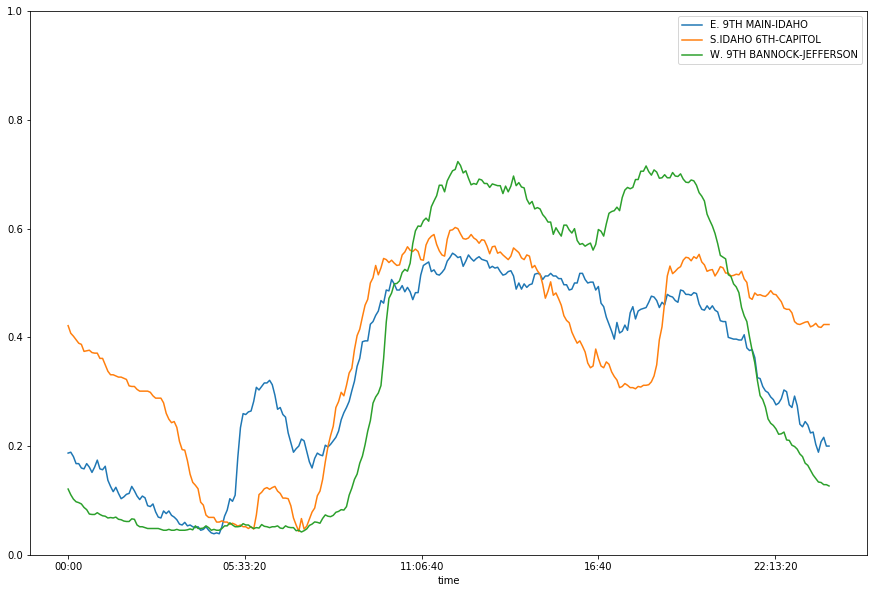

,Area,Date,DayOfWeek,Hour,Minute,OccupiedPercent
0,E. 9TH MAIN-IDAHO,2018-10-01,0,0,0,0.2
0,E. 9TH MAIN-IDAHO,2018-10-01,0,0,5,0.2
0,E. 9TH MAIN-IDAHO,2018-10-01,0,0,10,0.2
0,E. 9TH MAIN-IDAHO,2018-10-01,0,0,15,0.2
0,E. 9TH MAIN-IDAHO,2018-10-01,0,0,20,0.2
...,...,...,...,...,...,...
0,W. 9TH BANNOCK-JEFFERSON,2018-10-31,2,23,35,0.4
0,W. 9TH BANNOCK-JEFFERSON,2018-10-31,2,23,40,0.4
0,W. 9TH BANNOCK-JEFFERSON,2018-10-31,2,23,45,0.4
0,W. 9TH BANNOCK-JEFFERSON,2018-10-31,2,23,50,0.4


In [9]:
OccupiedTime(july_data, duration=5, graph=True)

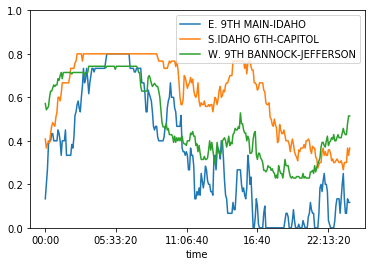

,Area,Date,DayOfWeek,Hour,Minute,OccupiedPercent
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,0,0.266667
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,5,0.266667
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,10,0.400000
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,15,0.533333
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,20,0.533333
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,25,0.533333
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,30,0.533333
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,35,0.533333
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,40,0.533333
0,E. 9TH MAIN-IDAHO,2019-07-06,5,0,45,0.533333


In [8]:
# Or for just the weekends in July
OccupiedTime(july_data, duration=5, weekdays=[5], graph=True)

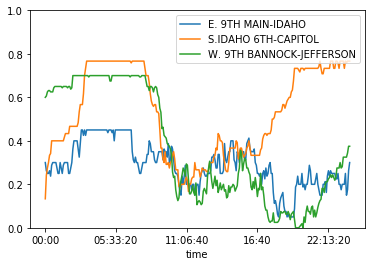

,Area,Date,DayOfWeek,Hour,Minute,OccupiedPercent
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,0,0.400
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,5,0.250
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,10,0.200
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,15,0.200
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,20,0.200
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,25,0.100
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,30,0.150
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,35,0.200
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,40,0.200
0,E. 9TH MAIN-IDAHO,2018-10-06,5,0,45,0.200


In [22]:
# Or for just the weekends in July
OccupiedTime(july_data, duration=5, weekdays=[5], graph=True)

In [34]:
# If you have some arbitrary saved Pickle file you want to load later, this is how that is done
with open("data/preprocessed_sample.p", "rb") as iFile:
    pmData = pickle.load(iFile)
pmData.head()

,Area,Date,DayOfWeek,Hour,Minute,OccupiedPercent
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,0,0.000000
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,15,0.088889
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,30,0.300000
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,45,0.311111
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,1,0,0.311111


In [72]:
# Pass in our preprocessed data that we got from calling OccupiedTime with our desired query and build our Logistical Regression Model
# This will print its accuracy score and hand back a model that you can feed new data into to get predicted results
model = BuildModel(pmData)

C:\Users\brody\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\brody\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8141315002466176


In [ ]:
model.predict()

In [40]:
pmData.head()

,Area,Date,DayOfWeek,Hour,Minute,OccupiedPercent
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,0,0.000000
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,15,0.088889
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,30,0.300000
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,0,45,0.311111
0,W. 8TH MYRTLE/BROAD,2018-07-01,6,1,0,0.311111


In [41]:
len(pmData)

800832

In [17]:
ot.head()

,index,Area,Date,DayOfWeek,Hour,Minute,Latitude,Longitude,OccupiedPercent,Location_Ending_Longitude,Location_Ending_Latitude,Location_Starting_Longitude,Location_Starting_Latitude
0,0,8TH. ST,2018-01-01,0,0,0,43.616005,-116.203005,0.596154,43.617104,-116.202013,43.615636,-116.203416
1,0,8TH. ST,2018-01-01,0,1,0,43.616005,-116.203005,0.589744,43.617104,-116.202013,43.615636,-116.203416
2,0,8TH. ST,2018-01-01,0,2,0,43.616005,-116.203005,0.507692,43.617104,-116.202013,43.615636,-116.203416
3,0,8TH. ST,2018-01-01,0,3,0,43.616005,-116.203005,0.370513,43.617104,-116.202013,43.615636,-116.203416
4,0,8TH. ST,2018-01-01,0,4,0,43.616005,-116.203005,0.155128,43.617104,-116.202013,43.615636,-116.203416


In [18]:
ot_out = ot[['Area','Date','DayOfWeek', 'Hour', 'Minute','OccupiedPercent']]

In [19]:
ot_out

,Area,Date,DayOfWeek,Hour,Minute,OccupiedPercent
0,8TH. ST,2018-01-01,0,0,0,0.596154
1,8TH. ST,2018-01-01,0,1,0,0.589744
2,8TH. ST,2018-01-01,0,2,0,0.507692
3,8TH. ST,2018-01-01,0,3,0,0.370513
4,8TH. ST,2018-01-01,0,4,0,0.155128
...,...,...,...,...,...,...
744595,W.9TH JEFFERSON-STATE,2018-12-29,5,19,0,0.972222
744596,W.9TH JEFFERSON-STATE,2018-12-29,5,20,0,0.980556
744597,W.9TH JEFFERSON-STATE,2018-12-29,5,21,0,0.936111
744598,W.9TH JEFFERSON-STATE,2018-12-29,5,22,0,0.652778


In [20]:
pickle.dump(ot_out, open( "data/2018.p", "wb" ))